<>:84: SyntaxWarning: invalid escape sequence '\e'
<>:85: SyntaxWarning: invalid escape sequence '\s'
<>:84: SyntaxWarning: invalid escape sequence '\e'
<>:85: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Jaime\AppData\Local\Temp\ipykernel_36824\1179321043.py:84: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon \\text{ }(-)$')
C:\Users\Jaime\AppData\Local\Temp\ipykernel_36824\1179321043.py:85: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma_{S} \\text{ }(kPa\cdot m^3/kg)$')


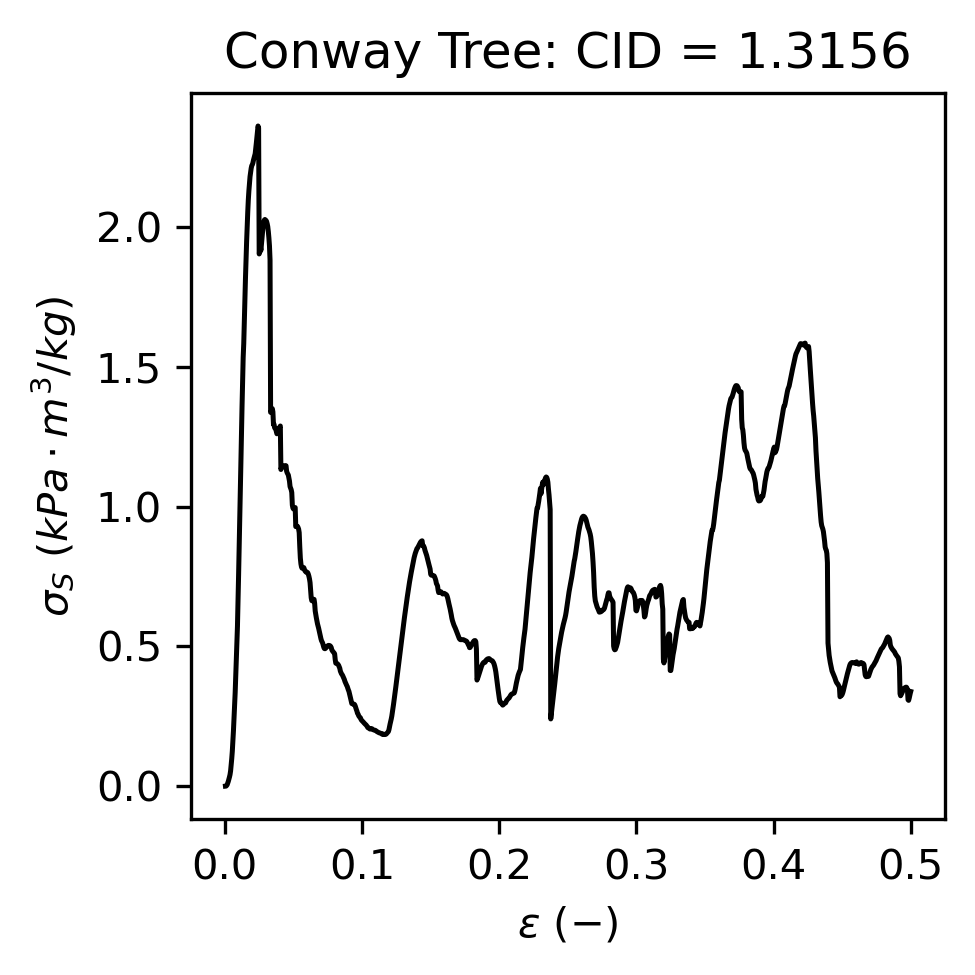

In [15]:
#!/usr/bin/env python
# coding: utf-8
"""
Minimal plotter: specific compressive stress vs. engineering strain
===================================================================
• Reads every “Test Run <n>” sub-folder in `main_folder_path`
• Computes strain, stress, and specific stress
• Plots a single curve for each run (no peak markers, no overlays)
• Saves PNGs to `Data/Crack_Arrest_Notebook_Saves/`
"""

# ───── imports ──────────────────────────────────────────────────
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ───── constants ────────────────────────────────────────────────
L0_MM      = 36.0          # gauge length in mm
SIDE_MM    = 30.0          # cross-section side length in mm
AREA_M2    = (SIDE_MM*1e-3) ** 2     # m²
VOXEL_SIDE = 1.0           # mm (voxel edge length assumed 1 mm)
PLA_DENS_G_CM3 = 1.25
DENS_KG_MM3    = PLA_DENS_G_CM3 * 1e-6   #  g → kg, cm⁻³ → mm⁻³
NET_VOL_MM3    = SIDE_MM**3              # printed cube, mm³
SAVE_DIR  = 'Data/Crack_Arrest_Notebook_Saves'
MAIN_DIR  = 'Data/MTS_Runs'

# sample metadata (unchanged; gives Voxel Count per run)
sample_data = {
    'Sample Name': [1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 16, 17, 18, 'central branch', 'corner branch',
                    '2 branches', '4 branches', '5 branches', 'AF360GD 1000N', 'AF360GD 200N'],
    'Run Number': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 21, 24, 20, 23, 19, 18],
    'CID': [1.3512, 1.3244, 1.2799, 1.2000, 1.0578, 1.3156, 
            1.3244, 1.3689, 1.3156, 1.2268, 1.3423, 1.3423, 
            1.3156, 1.2799, 0.4178, 0.4411, 0.5811, 0.8222, 
            0.9688, 'N/A', 'N/A'],
    'Voxel Count': [5660, 2441, 2395, 1510, 1081, 3128, 4389, 5500, 2569, 1785, 4769, 6050, 3637, 3454, 1488, 1108, 1791, 2983, 4305, 4059, 3809]
}

vox_df = pd.DataFrame(sample_data).set_index('Run Number')

# ───── helpers ──────────────────────────────────────────────────
rx_run = re.compile(r'Test Run (\d+)', re.I)
def run_num(folder_name:str) -> int|None:
    m = rx_run.search(folder_name);  return int(m.group(1)) if m else None

# ───── I/O setup ────────────────────────────────────────────────
os.makedirs(SAVE_DIR, exist_ok=True)

subfolders = [f.path for f in os.scandir(MAIN_DIR) if f.is_dir()]
runs = sorted( (run_num(os.path.basename(f)), f) for f in subfolders if run_num(os.path.basename(f)) )

# pick the run we care about
SELECTED_RUN = 12          # change this if you want another sample

# ─── main loop ────────────────────────────────────────────────
for run_id, folder in runs:
    if run_id != SELECTED_RUN:
        continue                          # skip all other runs

    dat_file = os.path.join(folder, 'DAQ- Crosshead, … - (Timed).txt')
    if not os.path.isfile(dat_file):
        raise FileNotFoundError(f"Data file missing for run {run_id}")

    # ── load & compute ────────────────────────────────────────
    df = pd.read_csv(dat_file, sep='\t', skiprows=7)
    df['strain']  = (df['mm'] * 1e-3) / (L0_MM*1e-3)
    df['stress']  = (df['kN'] * 1e3) / AREA_M2

    # specific stress
    voxels = vox_df.loc[run_id, 'Voxel Count']
    mass_kg = voxels * DENS_KG_MM3 * VOXEL_SIDE**3
    # inside the loop, right after you compute `mass_kg`
    volume_m3        = NET_VOL_MM3 * 1e-9          # mm³ ➜ m³
    density_kgm3     = mass_kg / volume_m3         # kg / m³
    df['specific_stress_kPa'] = (df['stress'] / density_kgm3) / 1e3  # kPa·m³/kg

    # plot
    cid_val = vox_df.loc[run_id, 'CID']
    plt.figure(figsize=(3.35,3.35), dpi=300) #single column figure dimensions as per:
    '''https://advanced.onlinelibrary.wiley.com/hub/journal/15214095/author-guidelines#:~:text=Figures%20and%20tables%20should%20have,be%20submitted%20in%20separate%20files.'''
    plt.plot(df['strain'], df['specific_stress_kPa'], 'k-', lw=1.2)
    plt.xlabel('$\epsilon \\text{ }(-)$')
    plt.ylabel('$\sigma_{S} \\text{ }(kPa\cdot m^3/kg)$')
    plt.title(f'Conway Tree: CID = {cid_val}')
    plt.tight_layout()
    plt.ticklabel_format(style='plain', axis='y')   # no scientific-notation offset
    plt.show()

    break        